## Model Training

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("preprocessed_churn_data.csv")

### Let's have a look at the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Tenure           100000 non-null  int64  
 1   Monthly_Charges  100000 non-null  float64
 2   Total_Charges    100000 non-null  float64
 3   Support_Calls    100000 non-null  int64  
 4   Contract_Type    100000 non-null  int64  
 5   Churn            100000 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 4.6 MB


In [3]:
df.head()

,Tenure,Monthly_Charges,Total_Charges,Support_Calls,Contract_Type,Churn
0,16,113.67,1830.01,3,2,1
1,33,79.14,2637.01,2,0,1
2,54,103.80,5617.29,2,2,1
3,37,92.47,3413.67,2,0,1
4,20,71.72,1437.29,0,1,0


Let us prepare the data for model training

### Preprocessing Pipeline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.pipeline import Pipeline
import pandas as pd

# Separate features and target
X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']

# Identify feature types
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, dtype=int), cat_features)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit-transform on training data, transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Numerical features: ['Tenure', 'Monthly_Charges', 'Total_Charges', 'Support_Calls', 'Contract_Type']
Categorical features: []


### Creating a function to evaluate the models

In [7]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import numpy as np

def evaluate_classification_model(true, predicted, proba=None):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc = roc_auc_score(true, proba if proba is not None else predicted)
    fpr, tpr, thresholds = roc_curve(true, proba if proba is not None else predicted)
    return acc, f1, roc, fpr, tpr, thresholds

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [16]:
# Define regression models
regression_models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(tree_method='hist',device='cuda')
}

# Create DataFrames to store the results
train_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC Score', 'Accuracy'])
test_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC Score', 'Accuracy'])

# Train and evaluate models
for model_name, model in regression_models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_preprocessed, y_train)

    train_pred = model.predict(X_train_preprocessed)
    test_pred = model.predict(X_test_preprocessed)

    # Evaluate on train and test data
    train_acc, train_f1, train_roc, train_fpr, train_tpr, train_thresh = evaluate_classification_model(y_train, train_pred)
    test_acc, test_f1, test_roc, test_fpr, test_tpr, test_thresh = evaluate_classification_model(y_test, test_pred)

    # Store results
    train_results.loc[len(train_results)] = [model_name, train_f1, train_roc, train_acc]
    test_results.loc[len(test_results)] = [model_name, test_f1, test_roc, test_acc]

# View the results
print("\nTrain Results:\n", train_results)
print("\nTest Results:\n", test_results)


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training XGBoost...

Train Results:
                  Model  F1 Score  ROC Score  Accuracy
0  Logistic Regression  0.940693   0.883814  0.913000
1        Decision Tree  1.000000   1.000000  1.000000
2        Random Forest  0.999991   0.999991  0.999988
3    Gradient Boosting  0.978124   0.957345  0.968063
4             AdaBoost  0.968817   0.930360  0.953975
5              XGBoost  0.982864   0.968020  0.975038

Test Results:
                  Model  F1 Score  ROC Score  Accuracy
0  Logistic Regression  0.941788   0.882265   0.91380
1        Decision Tree  0.968994   0.940361   0.95440
2        Random Forest  0.975137   0.952349   0.96345
3    Gradient Boosting  0.978267   0.956769   0.96800
4             AdaBoost  0.968065   0.927895   0.95250
5              XGBoost  0.977639   0.957692   0.96715


#### These are the training results

In [17]:
train_results = train_results.sort_values(by='Accuracy', ascending=False).reset_index(drop= True)
train_results

,Model,F1 Score,ROC Score,Accuracy
0,Decision Tree,1.000000,1.000000,1.000000
1,Random Forest,0.999991,0.999991,0.999988
2,XGBoost,0.982864,0.968020,0.975038
3,Gradient Boosting,0.978124,0.957345,0.968063
4,AdaBoost,0.968817,0.930360,0.953975
5,Logistic Regression,0.940693,0.883814,0.913000


In [18]:
test_results = test_results.sort_values(by='Accuracy', ascending=False).reset_index(drop= True)
test_results

,Model,F1 Score,ROC Score,Accuracy
0,Gradient Boosting,0.978267,0.956769,0.96800
1,XGBoost,0.977639,0.957692,0.96715
2,Random Forest,0.975137,0.952349,0.96345
3,Decision Tree,0.968994,0.940361,0.95440
4,AdaBoost,0.968065,0.927895,0.95250
5,Logistic Regression,0.941788,0.882265,0.91380


Looking at the above data, it is clearly evident that the some of the modesl like Decision Trees, Random Forest, etc. are over fitting on training data. Hence, we need to perform hyperparameter tuning of the models to avoid over fitting.

### 🔧 Let Us Perform Hyperparameter Tuning on select models

In [15]:
param_dict = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "penalty": ["l1", "l2", "elasticnet", None],
            "C": [0.01, 0.1, 1, 10],
            "solver": ["saga"],
            "max_iter": [100, 200]
        }
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "bootstrap": [True, False]
        }
    },
    "GradientBoostingClassifier": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0]
        }
    },
    "AdaBoostClassifier": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "algorithm": ['SAMME', 'SAMME.R']
        }
    },
    "XGBClassifier": {
        "model": XGBClassifier(tree_method='hist', device='cuda'),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}


In [19]:
from sklearn.model_selection import RandomizedSearchCV

# Create results DataFrames
train_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC Score', 'Accuracy'])
test_results = pd.DataFrame(columns=['Model', 'F1 Score', 'ROC Score', 'Accuracy'])
best_params_df = pd.DataFrame(columns=['Model', 'Best Parameters'])

# Loop through each model in the param_grids dictionary
for model_name, config in param_dict.items():
    print(f"\n🔍 Tuning and training {model_name}...")

    model = config['model']
    param_grid = config['params']

    grid = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs= 2, verbose=0)
    grid.fit(X_train_preprocessed, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Predictions
    train_pred = best_model.predict(X_train_preprocessed)
    test_pred = best_model.predict(X_test_preprocessed)

    # Probabilities for ROC AUC
    train_proba = best_model.predict_proba(X_train_preprocessed)[:, 1] if hasattr(best_model, "predict_proba") else None
    test_proba = best_model.predict_proba(X_test_preprocessed)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Evaluation
    train_acc, train_f1, train_roc, *_ = evaluate_classification_model(y_train, train_pred, train_proba)
    test_acc, test_f1, test_roc, *_ = evaluate_classification_model(y_test, test_pred, test_proba)

    # Store results
    train_results.loc[len(train_results)] = [model_name, train_f1, train_roc, train_acc]
    test_results.loc[len(test_results)] = [model_name, test_f1, test_roc, test_acc]
    best_params_df.loc[len(best_params_df)] = [model_name, best_params]


🔍 Tuning and training LogisticRegression...


/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Ch

✅ Best Parameters for LogisticRegression: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 1}

🔍 Tuning and training DecisionTreeClassifier...
✅ Best Parameters for DecisionTreeClassifier: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}

🔍 Tuning and training RandomForestClassifier...
✅ Best Parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}

🔍 Tuning and training GradientBoostingClassifier...
✅ Best Parameters for GradientBoostingClassifier: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}

🔍 Tuning and training AdaBoostClassifier...


/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parame

✅ Best Parameters for AdaBoostClassifier: {'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME'}

🔍 Tuning and training XGBClassifier...


/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [13:16:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [13:16:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Pot

✅ Best Parameters for XGBClassifier: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


#### These are the training results after hyperparameter tuning

In [20]:
train_results = train_results.sort_values(by='Accuracy', ascending=False).reset_index(drop= True)
train_results

,Model,F1 Score,ROC Score,Accuracy
0,RandomForestClassifier,0.982133,0.997502,0.973975
1,DecisionTreeClassifier,0.980547,0.996888,0.971675
2,GradientBoostingClassifier,0.979927,0.996359,0.970738
3,XGBClassifier,0.978993,0.996089,0.969413
4,AdaBoostClassifier,0.968817,0.991404,0.953975
5,LogisticRegression,0.940742,0.969729,0.913075


#### These are the test results after hyperparameter tuning

In [21]:
test_results = test_results.sort_values(by='Accuracy', ascending=False).reset_index(drop= True)
test_results

,Model,F1 Score,ROC Score,Accuracy
0,GradientBoostingClassifier,0.979053,0.995771,0.96920
1,XGBClassifier,0.978403,0.995690,0.96830
2,RandomForestClassifier,0.977852,0.995241,0.96745
3,DecisionTreeClassifier,0.976754,0.989941,0.96585
4,AdaBoostClassifier,0.968065,0.990612,0.95250
5,LogisticRegression,0.941780,0.969911,0.91380


Looking at the evaluation metrics on test data, both **GradientBoostingClassifier** and **XGBClassifier** demonstrate strong performance, each achieving an accuracy of approximately **96%**. Given the large training dataset (80,000 rows), **XGBClassifier** is a more practical choice due to its support for **GPU acceleration**. Leveraging the GPU significantly reduces training time and resource consumption, making it well-suited for scalable and efficient model development.

In [22]:
best_params_df[best_params_df['Model'] == 'XGBClassifier']['Best Parameters'].iloc[0]

{'subsample': 0.8,
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [23]:
best_params = {'subsample': 0.8,
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

### Let us train the final model and Cross Validate it

#### Final Model Training

In [24]:
final_model = XGBClassifier(**best_params, tree_method='hist', device='cuda')
final_model.fit(X_train_preprocessed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

#### Cross Validation

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(final_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy', n_jobs=2)
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.9695    0.9665625 0.9699375 0.9664375 0.969    ]
Mean CV Accuracy: 0.9682875000000001


### Feature Importance

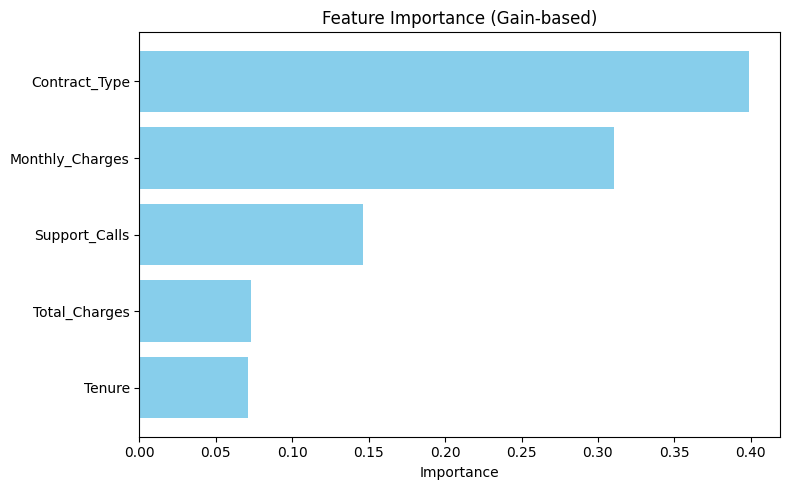

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Your feature names
features = ['Tenure', 'Monthly_Charges', 'Total_Charges', 'Support_Calls', 'Contract_Type']

# Get importance
importances = final_model.feature_importances_

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Gain-based)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This **Feature Importance (Gain-based)** plot from the final tuned `XGBClassifier` gives valuable insight into **which features the model relies on most** when making predictions.

### 🔍 Interpretation of Feature Importance:

1. **Contract\_Type (\~0.40 Gain)**

   * ✅ **Most important feature.**
   * The model found this feature most valuable for splitting the data and reducing prediction error.
   * Likely indicates **contract length (e.g., month-to-month vs. yearly)** plays a major role in predicting the target (e.g., churn, default, etc.).

2. **Monthly\_Charges (\~0.31 Gain)**

   * 🚀 **Second most important.**
   * Indicates the **cost per month** is strongly predictive.
   * Higher or lower charges may signal different customer segments or risk levels.

3. **Support\_Calls (\~0.15 Gain)**

   * 📞 Moderate importance.
   * Number of support calls can correlate with dissatisfaction or product issues—important but not as dominant.

4. **Total\_Charges (\~0.07 Gain)**

   * 💸 Less important than monthly charges.
   * Likely contains overlapping information with `Tenure × Monthly_Charges`.

5. **Tenure (\~0.07 Gain)**

   * ⏳ Least important.
   * Indicates how long the user has been with the company—might be less directly predictive or correlated with other variables.

---

### 🔗 What does “Gain” mean?

* **Gain** = How much a feature **contributes to reducing model error** when it's used in tree splits.
* Higher gain = More impact on improving the model's accuracy.

---

### ✅ Takeaways:

* Focus on **Contract\_Type and Monthly\_Charges** if we want to:

  * Create simplified models
  * Explain decisions to stakeholders
  * Perform feature selection for business rules
* Features with **low gain (e.g., Tenure)** aren’t useless, but they might not add much value to the model on their own.



### Let us plot the Confusion Matrix

accuracy Score:  0.9683
f1 Score:  0.9784030521869465
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5313
           1       0.98      0.98      0.98     14687

    accuracy                           0.97     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000



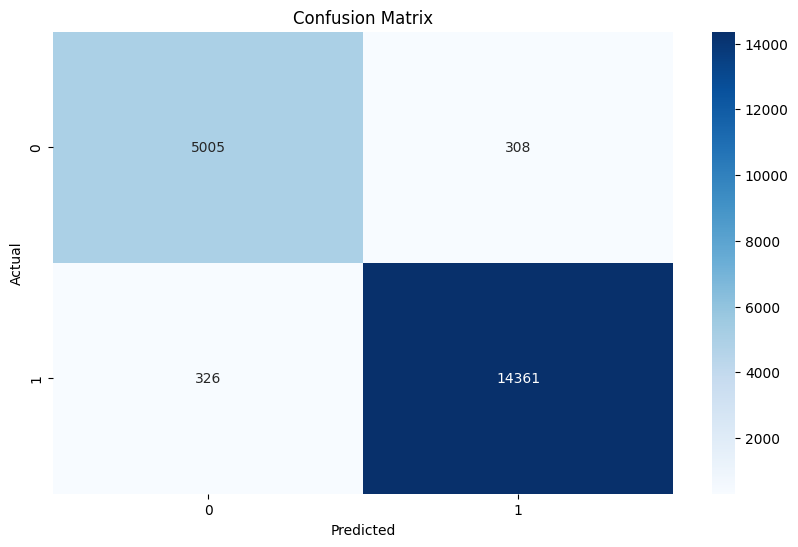

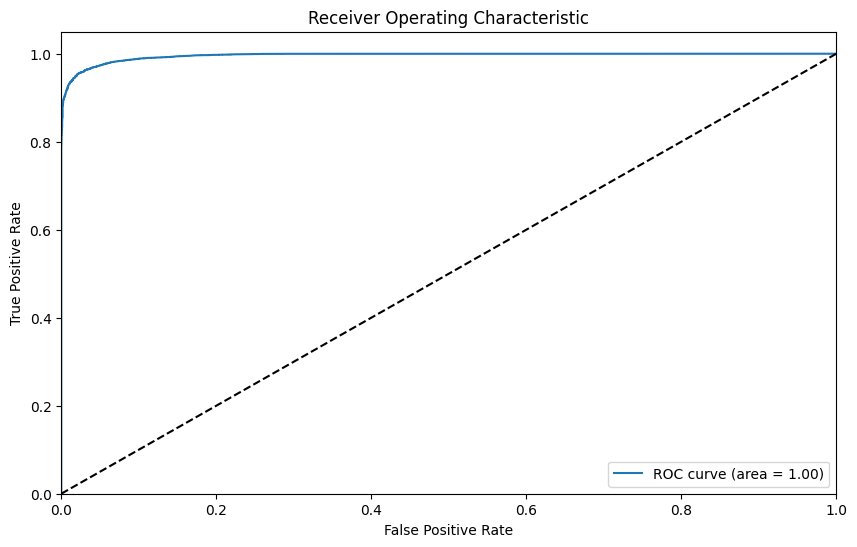

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = final_model.predict(X_test_preprocessed)
y_pred_proba = final_model.predict_proba(X_test_preprocessed)[:, 1]
print("accuracy Score: ", accuracy_score(y_test, y_pred))
print("f1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Plot Interpretation

 1. **Confusion Matrix Interpretation**
This confusion matrix is based on a binary classification:

|              | **Predicted 0** | **Predicted 1** |
| ------------ | --------------- | --------------- |
| **Actual 0** | **5005** (TN)   | **308** (FP)    |
| **Actual 1** | **326** (FN)    | **14,361** (TP) |


📌 Key Metrics:

* True Positives (TP): 14,361 — Model correctly predicted class 1.

* True Negatives (TN): 5,005 — Model correctly predicted class 0.

* False Positives (FP): 308 — Model incorrectly predicted 1 when it was 0.

* False Negatives (FN): 326 — Model incorrectly predicted 0 when it was 1.


✅ Model Performance Summary:
* High TP and TN values indicate strong predictive performance.

- Low FP and FN values show minimal misclassification.

- Balanced handling of both classes.


✅ 2. **ROC Curve Interpretation**

🧾 ROC Details:
- ROC Curve shows the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR).

- Area Under the Curve (AUC) ≈ 97.00% (as annotated on the plot).


✅ **Interpretation**:
- An AUC of 1.00 suggests perfect classification performance — the model separates both classes flawlessly.

- The curve hugs the top-left corner → almost no false positives with high true positives.

🟢 **Final Assessment**:

The XGBoost classifier is:

- Extremely well-tuned.

- Generalizing well.

- Producing high accuracy, precision, and recall.

### Let us save the model using pickle

In [41]:
import os
import pickle

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the preprocessor
with open('models/Churn_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('models/Churn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Preprocessor and model saved successfully!")

Preprocessor and model saved successfully!
